In [1]:
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from autorocks.viz import plots_setup
import torch
import gpytorch
import botorch.posteriors
from botorch import models
from botorch.optim import fit
import torch
import numpy as np
import pandas as pd
import botorch

output_location = "/Users/salabed/workspace/latex_writings/thesis/phd_dissertation/Chapters/Background/Figures/"

problem = botorch.test_functions.BraninCurrin(negate = True)

standard_bounds = torch.zeros(2, problem.dim, dtype = torch.float64)
standard_bounds[1] = 1


In [3]:
num_observations = 5
num_restarts = 5
num_optimization_rounds = 30
initial_train_x, initial_train_y = plots_setup.generate_data(num_observations, problem)

test_x, test_y = plots_setup.generate_data(100, problem)


def negative_log_predictive_density(
    pred_dist: gpytorch.distributions.MultivariateNormal,
    test_y: torch.Tensor,
) -> torch.Tensor:
    # https://docs.gpytorch.ai/en/v1.9.0/_modules/gpytorch/metrics/metrics.html
    combine_dim = -2 if isinstance(pred_dist, gpytorch.distributions.MultitaskMultivariateNormal) else -1
    return -pred_dist.log_prob(test_y) / test_y.shape[combine_dim]



In [4]:
# Train two independent GP to model the tasks. 

from botorch.models.transforms.outcome import Standardize

independent_pred = []
for restart in range(num_restarts):
    train_x = initial_train_x.clone()
    for step in range(num_optimization_rounds):
        # fit the model 
        train_y = problem(train_x)
        model = models.FixedNoiseGP(
            train_X = train_x,
            train_Y = train_y,
            train_Yvar = torch.zeros_like(train_y),
            outcome_transform = Standardize(m = 2),
        )
        # Fit and train the model
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
        fit.fit_gpytorch_mll_scipy(mll)

        model.eval()
        with torch.no_grad():
            weights = torch.ones(train_y.shape[-1], dtype = torch.double)
            trained_pred_dist = model.posterior(
                X = test_x, posterior_transform = botorch.acquisition.ScalarizedPosteriorTransform(
                    weights)
            )
            score = negative_log_predictive_density(trained_pred_dist.mvn, test_y.sum(-1))
        weights = torch.ones(train_y.shape[-1], dtype = torch.double)
        best_f = train_y.sum(-1, keepdim = True).max()
        acf = botorch.acquisition.ExpectedImprovement(model, best_f = best_f,
                                                      posterior_transform = botorch.acquisition.ScalarizedPosteriorTransform(
                                                          weights)
                                                      )
        new_candidate, acf_value = botorch.optim.optimize_acqf(
            acf, bounds = torch.tensor(problem._bounds).T, q = 1, num_restarts = 1, raw_samples = 64)
        train_x = torch.concat([train_x, new_candidate])
        independent_pred.append({
            "score": float(score.detach().cpu().numpy()),
            "candidate": new_candidate.detach().cpu().numpy(),
            "best_f": float(best_f.detach().cpu().numpy()),
            "model": "Independent",
            "step": step,
            "restart": restart
        })

/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to

In [5]:
# JOINT
joint_pred = []
train_x = initial_train_x.clone()
for restart in range(num_restarts):
    for step in range(num_optimization_rounds):
        # fit the model 
        train_y = problem(train_x).sum(-1, keepdim = True)
        model = models.FixedNoiseGP(
            train_X = train_x,
            train_Y = train_y,
            train_Yvar = torch.zeros_like(train_y),
            outcome_transform = Standardize(m = 1),
        )
        # Fit and train the model
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
        fit.fit_gpytorch_mll_scipy(mll)

        model.eval()
        with torch.no_grad():
            trained_pred_dist = model.posterior(X = test_x)
            score = negative_log_predictive_density(trained_pred_dist.mvn, test_y.sum(-1))
        best_f = train_y.max()
        acf = botorch.acquisition.ExpectedImprovement(model, best_f = best_f)
        new_candidate, acf_value = botorch.optim.optimize_acqf(
            acf, bounds = torch.tensor(problem._bounds).T, q = 1, num_restarts = 1, raw_samples = 64)
        train_x = torch.concat([train_x, new_candidate])
        joint_pred.append({
            "score": float(score.detach().cpu().numpy()),
            "candidate": new_candidate.detach().cpu().numpy(),
            "best_f": float(best_f.detach().cpu().numpy()),
            "model": "Joint",
            "step": step,
            "restart": restart
        })


/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to

In [6]:
# MT

mt_pred = []
for restart in range(num_restarts):
    train_x = initial_train_x.clone()
    for step in range(num_optimization_rounds):
        # fit the model 
        train_y = problem(train_x)

        train_x_f1 = torch.hstack([train_x, torch.zeros(train_x.shape[0], 1)])
        train_x_f2 = torch.hstack([train_x, torch.ones(train_x.shape[0], 1)])

        model = models.FixedNoiseMultiTaskGP(
            train_X = torch.concat([train_x_f1, train_x_f2]),
            train_Y = train_y.T.reshape(-1, 1),
            train_Yvar = torch.zeros_like(train_y.T.reshape(-1, 1)),
            task_feature = -1,
            outcome_transform = Standardize(m = 1),

        )
        # Fit and train the model
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
        fit.fit_gpytorch_mll_scipy(mll)

        model.eval()
        with torch.no_grad():
            trained_pred_dist = model.posterior(X = test_x)
            score = negative_log_predictive_density(trained_pred_dist.mvn,
                                                    test_y.T.reshape(-1, 1))
        weights = torch.ones(train_y.shape[-1], dtype = torch.double)
        best_f = train_y.sum(-1, keepdim = True)
        acf = botorch.acquisition.ExpectedImprovement(model,
                                                      best_f = botorch.utils.standardize(train_y).max(),
                                                      posterior_transform = botorch.acquisition.ScalarizedPosteriorTransform(
                                                          weights)
                                                      )
        new_candidate, acf_value = botorch.optim.optimize_acqf(
            acf, bounds = torch.tensor(problem._bounds).T.to(dtype = torch.double),
            q = 1, num_restarts = 1, raw_samples = 64)
        train_x = torch.concat([train_x, new_candidate])
        mt_pred.append({
            "score": float(score.detach().cpu().numpy()),
            "candidate": new_candidate.detach().cpu().numpy(),
            "best_f": float(best_f.max().detach().cpu().numpy()),
            "model": "MultiTask",
            "step": step,
            "restart": restart
        })


/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:607.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.wa

In [150]:
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

# Independent with MT
indp_mt_pred = []

import torch
from typing import Optional

from botorch.models.transforms.input import InputTransform
from botorch.models.transforms.outcome import OutcomeTransform
from gpytorch.distributions.multivariate_normal import MultivariateNormal
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.means.mean import Mean
from gpytorch.module import Module


class CustomGP(botorch.models.SingleTaskGP):
    def __init__(
        self,
        train_X: torch.Tensor,
        train_Y: torch.Tensor,
        likelihood: Optional[Likelihood] = None,
        covar_module: Optional[Module] = None,
        mean_module: Optional[Mean] = None,
        outcome_transform: Optional[OutcomeTransform] = None,
        input_transform: Optional[InputTransform] = None,
    ):
        mt_model = models.KroneckerMultiTaskGP(
            train_X = train_X,
            train_Y = train_Y,
            outcome_transform = Standardize(m = 2),
        )
        mt_mll = gpytorch.mlls.ExactMarginalLogLikelihood(mt_model.likelihood, mt_model)
        fit.fit_gpytorch_mll_scipy(mt_mll)
        mt_model.eval()
        super().__init__(
            train_X,
            train_Y.sum(-1, keepdim=True),
            likelihood,
            covar_module,
            mean_module,
            outcome_transform,
            botorch.models.transforms.input.Normalize(d=train_X.shape[-1]),
        )
        self.mt_model = mt_model

    def forward(self, x):
        x = self.mt_model.posterior(x).rsample().squeeze(0)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


for restart in range(num_restarts):
    print(f"{restart=}")
    train_x = initial_train_x.clone()
    for step in range(num_optimization_rounds):
        # fit the model 
        train_y = problem(train_x)
        std_train_y = botorch.utils.standardize(train_y)
        model = CustomGP(
            train_X = train_x,
            train_Y = train_y,
            outcome_transform = Standardize(m = 1),
        )
        # Fit and train the model
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
        fit.fit_gpytorch_mll_scipy(mll)
        model.eval()
        with torch.no_grad():
            trained_pred_dist = model.posterior(X = test_x)
            score = negative_log_predictive_density(trained_pred_dist.mvn,
                                                    botorch.utils.standardize(test_y.sum(-1, keepdim = False)))
        best_f = std_train_y.sum(-1, keepdim = True)
        acf = LogExpectedImprovement(model,
                                     best_f = best_f.max(),
                                     # sampler=SobolQMCNormalSampler(1024),
                                     #botorch.utils.standardize(train_y).max(),
                                     )
        new_candidate, acf_value = botorch.optim.optimize_acqf(
            acf, bounds = torch.tensor(problem._bounds).T.to(dtype = torch.double),
            q = 1, num_restarts = 1, raw_samples = 64)
        train_x = torch.concat([train_x, new_candidate])
        mt_pred.append({
            "score": float(score.detach().cpu().numpy()),
            "candidate": new_candidate.detach().cpu().numpy(),
            "best_f": float(train_y.sum(-1).max().detach().cpu().numpy()),
            "model": "CustomMultiTask",
            "step": step,
            "restart": restart
        })


restart=0


/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/e

restart=1


/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/e

restart=2


/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/e

restart=3


/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/e

restart=4


/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/salabed/opt/anaconda3/e

In [151]:
score

tensor(4.8972, dtype=torch.float64)

In [152]:

all_pred = independent_pred + joint_pred + mt_pred + indp_mt_pred

df = pd.DataFrame(all_pred)
df['score'] = df['score'].astype(float)
df['step'] = df['step'].astype(int)
df['restart'] = df['restart'].astype(int)
df

,score,candidate,best_f,model,step,restart
0,3.015562,"[[0.6542578, 0.0]]",-6.959732,Independent,0,0
1,2.870711,"[[0.0, 0.6532557]]",-6.959732,Independent,1,0
2,3.230292,"[[0.1453076, 1.0]]",-6.959732,Independent,2,0
3,3.074284,"[[0.1858482, 0.72747076]]",-6.959732,Independent,3,0
4,2.914294,"[[0.38536334, 0.0]]",-6.959732,Independent,4,0
...,...,...,...,...,...,...
680,4.979370,"[[0.2564751922760004, 0.6952488777613202]]",-5.862100,CustomMultiTask,25,4
681,4.873048,"[[0.28919298186596765, 0.1980656891017935]]",-5.862100,CustomMultiTask,26,4
682,4.991375,"[[0.2098641530145022, 0.9131445507891569]]",-5.862100,CustomMultiTask,27,4
683,4.943444,"[[0.1987808684497484, 0.656134590292115]]",-5.862100,CustomMultiTask,28,4


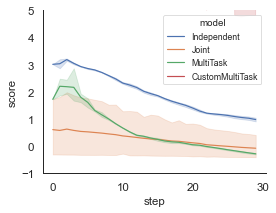

In [153]:
plt.style.use("ggplot")
sns.set_theme(style = "white", rc = {"axes.spines.right": False, "axes.spines.top": False})
sns.set_context("paper")  # , font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
plt.rc("text", usetex = False)
plt.rc("xtick", labelsize = "large")
plt.rc("ytick", labelsize = "large")
plt.rc("axes", labelsize = "large")
plt.rc("pdf", use14corefonts = True)

# Initialize plot
f, ax = plt.subplots(1, 1, figsize = (4, 3))

# x_axis is the number of observation
# y_axis is the score 

sns.lineplot(df, x = "step", y = "score", hue = "model", ax = ax)
# 

ax.set(ylim = (-1, 5))
# # Plot training data as red stars
# ax.plot(train_x_full.numpy(), train_y_full.numpy(), 'r*')
# # Plot predictive means as blue line
# ax.plot(test_x.numpy(), mean.numpy(), 'b')
# # Shade between the lower and upper confidence bounds
# ax.fill_between(test_x.numpy(), lower.squeeze().numpy(), upper.squeeze().numpy(), alpha = 0.2)
# ax.legend(['Observed Data', "Real Function", 'Mean', 'Confidence'])
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

output_format = "pdf"
# f.savefig(f"{output_location}/mt_score_comparison.{output_format}", bbox_inches = "tight", format = f"{output_format}",
#           dpi = 300)


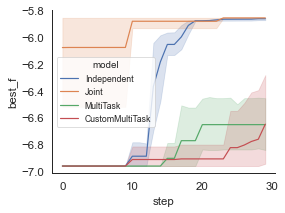

In [154]:
plt.style.use("ggplot")
sns.set_theme(style = "white", rc = {"axes.spines.right": False, "axes.spines.top": False})
sns.set_context("paper")  # , font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
plt.rc("text", usetex = False)
plt.rc("xtick", labelsize = "large")
plt.rc("ytick", labelsize = "large")
plt.rc("axes", labelsize = "large")
plt.rc("pdf", use14corefonts = True)

# Initialize plot
f, ax = plt.subplots(1, 1, figsize = (4, 3))

# x_axis is the number of observation
# y_axis is the score 

sns.lineplot(df, x = "step", y = "best_f", hue = "model", ax = ax)
# 

# ax.set(ylim = (-1, 5))
# # Plot training data as red stars
# ax.plot(train_x_full.numpy(), train_y_full.numpy(), 'r*')
# # Plot predictive means as blue line
# ax.plot(test_x.numpy(), mean.numpy(), 'b')
# # Shade between the lower and upper confidence bounds
# ax.fill_between(test_x.numpy(), lower.squeeze().numpy(), upper.squeeze().numpy(), alpha = 0.2)
# ax.legend(['Observed Data', "Real Function", 'Mean', 'Confidence'])
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

output_format = "pdf"
# f.savefig(f"{output_location}/mt_score_comparison.{output_format}", bbox_inches = "tight", format = f"{output_format}",
#           dpi = 300)


/var/folders/lr/bk98jc4x3r51f9vg3cdy_xww0000gr/T/ipykernel_45199/208158495.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data.explode(column=["f(x)", "x"]), x="x", y="f(x)", ax=ax, palette = "hls")


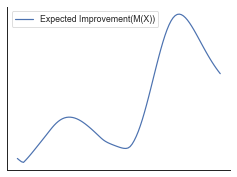

In [20]:
f, ax = plt.subplots(1, 1, figsize = (4, 3))

with torch.no_grad():
    ei = botorch.acquisition.ExpectedImprovement(model, best_f = train_y_full.min())(test_x.reshape(-1, 1, 1))

data = pd.DataFrame([
    {'AF': 'EI', 'f(x)': ei.numpy(), "x": test_x.numpy()},
])

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

ax = sns.lineplot(data.explode(column = ["f(x)", "x"]), x = "x", y = "f(x)", ax = ax, palette = "hls")
ax.legend(['Expected Improvement(M(X))'])

output_format = "png"
f.savefig(f"{output_location}/bo_loop_acf.{output_format}", bbox_inches = "tight", format = f"{output_format}",
          dpi = 300)


,AF,f(x),x
0,EI,0.204452,0.0
0,EI,0.202304,0.010101
0,EI,0.200021,0.020202
0,EI,0.1976,0.030303
0,EI,0.195042,0.040404
...,...,...,...
2,UCB,0.21884,0.959596
2,UCB,0.233687,0.969697
2,UCB,0.248211,0.979798
2,UCB,0.262392,0.989899
